## Importing dependencies

### First Party

Importing custom classes from the codebase:
- **dataset**: helper _torch_ wrapper around _facades_ dataset.
- **pix2pix**: implementation of _Pix2Pix_ architecture. Both generator and discriminator and the corresponding loss functions.

### Third Party

- **os**: to create directories, save weights.
- **opencv**: image processing library, helps to load/save images.
- **numpy**: nd arrays utilities, includes math and arithmetics.
- **torch**: ML framework, extremelly friendly to GPU, the network architecture was specifically designed in torch.
- **torchvision**: set of image transformations, like crop and flip. It is important to use _v2_ transforms as it can apply the same transformations to image and corresponding segmentation labels where stochastic operations used. 
- **matplotlib**: library to visualise data.
- **tqdm**: visualises progress.

In [1]:
# 3rd Party dependencies.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

# 1st Party dependencies.
from dataset.facades_dataset import FacadesDataset
from pix2pix.generator import Generator, GeneratorLoss
from pix2pix.discriminator import Discriminator, DiscriminatorLoss

%matplotlib inline

## Pre-processing data

I decided to apply the transformations described in [the original paper](https://arxiv.org/abs/1611.07004) (see paragraph 6.2 for more details): resize to _286×286_, random crop, and apply random mirroring.

In [2]:
# Default transforms are noted in the original paper
# in paragraph 6.2 as "Random jitter".
# The experiment is called "Cityscapes labels→photo".
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    # Resizing the 256×256 input images to 286×286.
    transforms.Resize((286, 286)), 
    # Randomly cropping back to size 256×256.
    transforms.RandomCrop(256),
    # Mirroring.
    transforms.RandomHorizontalFlip(),
])

default_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

## Loading dataset

- **train**: I will use this dataset for training the model. Train dataset uses special transformations.
- **val**: there is no need to use validation dataset as training generator is mostly unsupervised. Though, maybe it makes sense to test discriminator generalisation ability, I don't find it useful in the current setting. I am using _val_ split to just visually check _generator_ ability. Val does not use any transformation.

In [3]:
facades_train_dataset = FacadesDataset(root_dir='dataset/facades', split='train', transformations=train_transforms)
facades_val_dataset = FacadesDataset(root_dir='dataset/facades', split='val', transformations=default_transforms)

train_dataloader = DataLoader(facades_train_dataset, batch_size=1, shuffle=True)

Visualising _train dataset_ to check that the transformations are applied the same way to the real image and the condition (facade segmentation).
It is important to remember that the original images have **_BGR_ channels ordering**. Moreover, the model will **predict channels in the same order**.

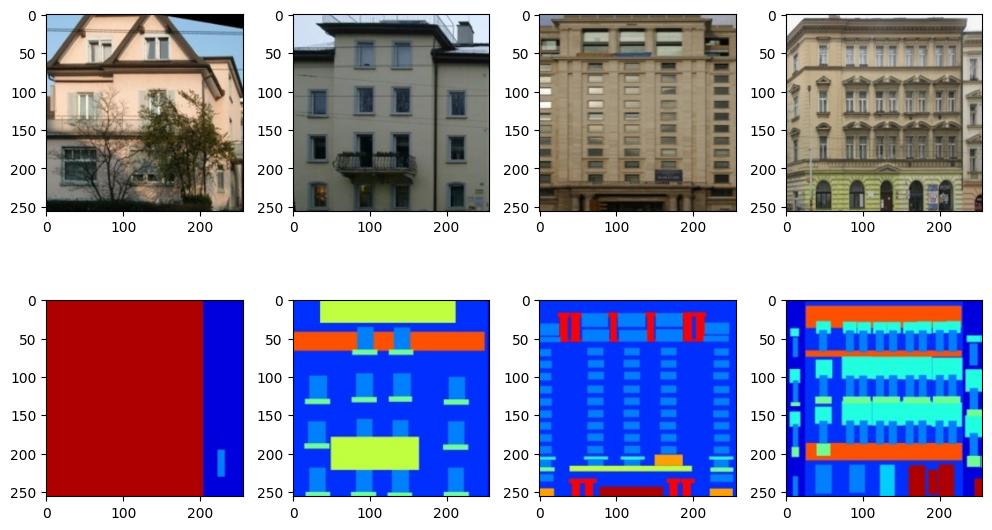

In [4]:
def visualise_dataset(dataset, indexes):
    figure, ax = plt.subplots(nrows=2, ncols=len(indexes), figsize=(10, 6))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))
        
        ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[1, i].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
    plt.tight_layout(pad=1)
    plt.show()    

visualise_dataset(facades_train_dataset, np.random.choice(range(len(facades_train_dataset)), 4))

## Running the training cycle

In the original paper they trained the model for _200 epochs_. Initially, I run the model in the same setting.
Though, it seems that generator can learn slightly more and produce more plausible _fakes_. I will try to train the model for _400 epochs_ and see whether 200th epoch checkpoint is different from 400th epoch.

In [ ]:
# Setup.
device = ('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 3 * 1e-4
epochs = 400

print('Starting training:', device, 'was selected for training')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

generator_loss = GeneratorLoss(alpha=100)
discriminator_loss = DiscriminatorLoss()

generator_history = []
discriminator_history = []

for epoch in range(epochs):

    generator_losses = []
    discriminator_losses = []

    for real, condition in tqdm(train_dataloader):        
        condition = condition.to(device)
        real = real.to(device)

        # Generator's loss.
        fake = generator(condition)
        fake_pred = discriminator(fake, condition)
        gl = generator_loss(fake, real, fake_pred)

        # Discriminator's loss.
        fake = generator(condition).detach()
        fake_pred = discriminator(fake, condition)
        real_pred = discriminator(real, condition)
        dl = discriminator_loss(fake_pred, real_pred)

        generator_optimizer.zero_grad()
        gl.backward()
        generator_optimizer.step()

        discriminator_optimizer.zero_grad()
        dl.backward()
        discriminator_optimizer.step()

        generator_losses.append(gl.item())
        discriminator_losses.append(dl.item())

    epoch_g_loss = np.mean(generator_losses)
    epoch_d_loss = np.mean(discriminator_losses)
    
    generator_history.append(epoch_g_loss)
    discriminator_history.append(epoch_d_loss)

    print('Epoch:', epoch, 'generator loss:', epoch_g_loss, 'discriminator loss:', epoch_d_loss)

    weights_dir = os.path.join('out', 'weights', 'pix2pix')
    os.makedirs(weights_dir, exist_ok=True)

    torch.save(generator.state_dict(), os.path.join(weights_dir, f"generator-{epoch:03d}-{epoch_g_loss:.3f}.pt"))
    torch.save(discriminator.state_dict(), os.path.join(weights_dir, f"discriminator-{epoch:03d}-{epoch_d_loss:.3f}.pt"))

Starting training: cuda was selected for training


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:25<00:00,  4.65it/s]


Epoch: 0 generator loss: 23.94700382709503 discriminator loss: 0.16356887585192453


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.56it/s]


Epoch: 1 generator loss: 24.927629475593566 discriminator loss: 0.0014987824067793554


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.90it/s]


Epoch: 2 generator loss: 26.03631437778473 discriminator loss: 0.000818176324974047


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.85it/s]


Epoch: 3 generator loss: 20.705649182796478 discriminator loss: 0.3884526294191164


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.54it/s]


Epoch: 4 generator loss: 23.407265944480898 discriminator loss: 0.13374603774864227


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:53<00:00,  7.49it/s]


Epoch: 5 generator loss: 23.201007046699523 discriminator loss: 0.13225170811812859


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:30<00:00, 13.07it/s]


Epoch: 6 generator loss: 21.301349692344665 discriminator loss: 0.2800971172354184


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.49it/s]


Epoch: 7 generator loss: 23.297798931598663 discriminator loss: 0.11941064456652384


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.41it/s]


Epoch: 8 generator loss: 21.866810331344606 discriminator loss: 0.23915966520144138


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.07it/s]


Epoch: 9 generator loss: 22.670347368717195 discriminator loss: 0.16353427682435723


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.32it/s]


Epoch: 10 generator loss: 21.494264345169068 discriminator loss: 0.22312684076838196


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.39it/s]


Epoch: 11 generator loss: 21.70024871587753 discriminator loss: 0.20236372653685974


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.43it/s]


Epoch: 12 generator loss: 21.801566114425658 discriminator loss: 0.1821437311178306


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.75it/s]


Epoch: 13 generator loss: 22.17918832063675 discriminator loss: 0.18298006746161263


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.43it/s]


Epoch: 14 generator loss: 21.59633321046829 discriminator loss: 0.24797792223631404


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.67it/s]


Epoch: 15 generator loss: 22.029230349063873 discriminator loss: 0.21042501957679632


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.01it/s]


Epoch: 16 generator loss: 21.864710595607757 discriminator loss: 0.19841249598481225


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.73it/s]


Epoch: 17 generator loss: 22.11311193227768 discriminator loss: 0.20093186064856128


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.80it/s]


Epoch: 18 generator loss: 22.015604734420776 discriminator loss: 0.17244613584771287


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.61it/s]


Epoch: 19 generator loss: 22.240477809906007 discriminator loss: 0.18000648361514324


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.27it/s]


Epoch: 20 generator loss: 22.33947913646698 discriminator loss: 0.17715155098063406


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.09it/s]


Epoch: 21 generator loss: 22.44096804857254 discriminator loss: 0.15319877932735834


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.57it/s]


Epoch: 22 generator loss: 22.137022688388825 discriminator loss: 0.1727318988450861


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.64it/s]


Epoch: 23 generator loss: 21.794097974300385 discriminator loss: 0.22334118264145217


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.47it/s]


Epoch: 24 generator loss: 20.888916795253753 discriminator loss: 0.2446019861480454


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.79it/s]


Epoch: 25 generator loss: 21.123424458503724 discriminator loss: 0.20543201530206714


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:29<00:00, 13.48it/s]


Epoch: 26 generator loss: 21.170530259609222 discriminator loss: 0.18888417083915557


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.61it/s]


Epoch: 27 generator loss: 21.6195716714859 discriminator loss: 0.17485372569499305


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.41it/s]


Epoch: 28 generator loss: 21.4947469830513 discriminator loss: 0.1885432054789271


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.14it/s]


Epoch: 29 generator loss: 21.757512075901033 discriminator loss: 0.1827376567266765


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.97it/s]


Epoch: 30 generator loss: 21.488072564601897 discriminator loss: 0.19956743143731728


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.13it/s]


Epoch: 31 generator loss: 21.35726019859314 discriminator loss: 0.19732793287170353


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.11it/s]


Epoch: 32 generator loss: 21.740226261615753 discriminator loss: 0.1640062254377699


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.80it/s]


Epoch: 33 generator loss: 21.816228477954866 discriminator loss: 0.1737026355768103


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.55it/s]


Epoch: 34 generator loss: 23.606845369338988 discriminator loss: 0.12008866558229783


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.82it/s]


Epoch: 35 generator loss: 22.47119832992554 discriminator loss: 0.1637907591208932


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.41it/s]


Epoch: 36 generator loss: 21.98283191204071 discriminator loss: 0.2099695873557357


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.71it/s]


Epoch: 37 generator loss: 22.1213933300972 discriminator loss: 0.15898592793506394


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.87it/s]


Epoch: 38 generator loss: 22.664156382083892 discriminator loss: 0.17455245667690178


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.30it/s]


Epoch: 39 generator loss: 21.715694191455842 discriminator loss: 0.186536161613476


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.69it/s]


Epoch: 40 generator loss: 21.527139437198638 discriminator loss: 0.18656546748239633


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.36it/s]


Epoch: 41 generator loss: 20.98572277545929 discriminator loss: 0.18208716295615887


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.73it/s]


Epoch: 42 generator loss: 21.350759351253508 discriminator loss: 0.18400380396815308


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.68it/s]


Epoch: 43 generator loss: 21.267141835689543 discriminator loss: 0.17630974912492092


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.14it/s]


Epoch: 44 generator loss: 20.906512513160706 discriminator loss: 0.19453423215803922


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.48it/s]


Epoch: 45 generator loss: 21.687831306457518 discriminator loss: 0.14190039252731368


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.23it/s]


Epoch: 46 generator loss: 20.671673860549927 discriminator loss: 0.2789348611352034


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.35it/s]


Epoch: 47 generator loss: 20.009065811634063 discriminator loss: 0.2227020399874891


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.87it/s]


Epoch: 48 generator loss: 20.107445774078368 discriminator loss: 0.1981036994699389


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.68it/s]


Epoch: 49 generator loss: 20.29704466342926 discriminator loss: 0.2036823588158586


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.94it/s]


Epoch: 50 generator loss: 19.74058809518814 discriminator loss: 0.2472762149238406


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.39it/s]


Epoch: 51 generator loss: 20.125061514377595 discriminator loss: 0.2035649554115662


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.64it/s]


Epoch: 52 generator loss: 19.78706540107727 discriminator loss: 0.19611304168502103


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.58it/s]


Epoch: 53 generator loss: 20.40985323667526 discriminator loss: 0.19846471136610488


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.10it/s]


Epoch: 54 generator loss: 19.890686135292054 discriminator loss: 0.2107911332740332


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.01it/s]


Epoch: 55 generator loss: 19.626064133644103 discriminator loss: 0.23266991942655296


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.27it/s]


Epoch: 56 generator loss: 19.454388930797577 discriminator loss: 0.24520738722712848


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:01<00:00,  6.50it/s]


Epoch: 57 generator loss: 19.622308404445647 discriminator loss: 0.21335752015962497


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:00<00:00,  6.64it/s]


Epoch: 58 generator loss: 19.68778563499451 discriminator loss: 0.19856684902289998


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.21it/s]


Epoch: 59 generator loss: 19.760996999740602 discriminator loss: 0.216377297132276


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:48<00:00,  8.25it/s]


Epoch: 60 generator loss: 19.942407281398772 discriminator loss: 0.2139876127122261


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.01it/s]


Epoch: 61 generator loss: 19.731403052806854 discriminator loss: 0.21351431260496612


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.57it/s]


Epoch: 62 generator loss: 19.56793084144592 discriminator loss: 0.20443124288271064


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.08it/s]


Epoch: 63 generator loss: 19.499893786907197 discriminator loss: 0.18967103836315802


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.82it/s]


Epoch: 64 generator loss: 19.80027770280838 discriminator loss: 0.20110056880599586


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.12it/s]


Epoch: 65 generator loss: 19.501718320846557 discriminator loss: 0.2157028096679278


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.26it/s]


Epoch: 66 generator loss: 19.436871225833894 discriminator loss: 0.19879381607403046


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.89it/s]


Epoch: 67 generator loss: 19.70210493326187 discriminator loss: 0.18658422810760386


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.81it/s]


Epoch: 68 generator loss: 19.24175529241562 discriminator loss: 0.22553929196845274


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.17it/s]


Epoch: 69 generator loss: 19.173195683956145 discriminator loss: 0.21293501843785634


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.67it/s]


Epoch: 70 generator loss: 19.277528860569 discriminator loss: 0.19286741838528543


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.09it/s]


Epoch: 71 generator loss: 18.675076513290406 discriminator loss: 0.24489425618667154


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.28it/s]


Epoch: 72 generator loss: 19.14367267847061 discriminator loss: 0.1945582325363648


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.26it/s]


Epoch: 73 generator loss: 19.135931129455567 discriminator loss: 0.23142572381111676


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.80it/s]


Epoch: 74 generator loss: 18.80773631334305 discriminator loss: 0.1909972559567541


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.78it/s]


Epoch: 75 generator loss: 19.07539330482483 discriminator loss: 0.20901778235143864


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.27it/s]


Epoch: 76 generator loss: 18.629930016994475 discriminator loss: 0.22330015985993668


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.86it/s]


Epoch: 77 generator loss: 18.775200476646422 discriminator loss: 0.22492562636936783


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.04it/s]


Epoch: 78 generator loss: 18.671951270103456 discriminator loss: 0.21899557823955548


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.29it/s]


Epoch: 79 generator loss: 18.59274925470352 discriminator loss: 0.20759998192836066


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.10it/s]


Epoch: 80 generator loss: 18.75831818819046 discriminator loss: 0.23723152199469041


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.39it/s]


Epoch: 81 generator loss: 18.23454349756241 discriminator loss: 0.24091341250168624


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.99it/s]


Epoch: 82 generator loss: 18.244315152168273 discriminator loss: 0.23686511852254624


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch: 83 generator loss: 18.3125692653656 discriminator loss: 0.2036339908154332


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.25it/s]


Epoch: 84 generator loss: 18.4737775015831 discriminator loss: 0.25369381664175306


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.05it/s]


Epoch: 85 generator loss: 18.071356704235075 discriminator loss: 0.21869979703355058


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.96it/s]


Epoch: 86 generator loss: 18.292269411087037 discriminator loss: 0.23616464333608747


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.41it/s]


Epoch: 87 generator loss: 17.87015720129013 discriminator loss: 0.23637081214459613


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.98it/s]


Epoch: 88 generator loss: 18.105469748973846 discriminator loss: 0.22660874853521817


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.53it/s]


Epoch: 89 generator loss: 17.914703648090363 discriminator loss: 0.2504151300329249


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.62it/s]


Epoch: 90 generator loss: 17.79826653957367 discriminator loss: 0.24382972990104462


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.33it/s]


Epoch: 91 generator loss: 17.63846604347229 discriminator loss: 0.22091804705560208


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.29it/s]


Epoch: 92 generator loss: 17.60008406639099 discriminator loss: 0.21877277430845424


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.60it/s]


Epoch: 93 generator loss: 17.933741509914398 discriminator loss: 0.2314492877025623


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.05it/s]


Epoch: 94 generator loss: 17.507236852645875 discriminator loss: 0.23869395535730292


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.48it/s]


Epoch: 95 generator loss: 17.599797372817992 discriminator loss: 0.25387441001832484


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.07it/s]


Epoch: 96 generator loss: 17.578898651599886 discriminator loss: 0.23864019487635232


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.61it/s]


Epoch: 97 generator loss: 17.4268830537796 discriminator loss: 0.22125952914211666


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 11.06it/s]


Epoch: 98 generator loss: 17.53759422302246 discriminator loss: 0.23213302451127674


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.25it/s]


Epoch: 99 generator loss: 17.697393021583558 discriminator loss: 0.212861313726753


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.38it/s]


Epoch: 100 generator loss: 17.60792887210846 discriminator loss: 0.2299030966567807


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:43<00:00,  9.24it/s]


Epoch: 101 generator loss: 17.132680599689483 discriminator loss: 0.2643943030142691


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.63it/s]


Epoch: 102 generator loss: 17.571680195331574 discriminator loss: 0.21857799424920812


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.79it/s]


Epoch: 103 generator loss: 17.39783955335617 discriminator loss: 0.2140656722721178


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.80it/s]


Epoch: 104 generator loss: 17.452232661247255 discriminator loss: 0.215534567956347


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:47<00:00,  8.34it/s]


Epoch: 105 generator loss: 17.003670885562897 discriminator loss: 0.27300745388347425


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.02it/s]


Epoch: 106 generator loss: 17.280102486610414 discriminator loss: 0.20764397695107617


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:32<00:00, 12.24it/s]


Epoch: 107 generator loss: 17.258732302188875 discriminator loss: 0.22501645308861043


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.47it/s]


Epoch: 108 generator loss: 17.32547571182251 discriminator loss: 0.2336192936229054


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.51it/s]


Epoch: 109 generator loss: 17.38104063510895 discriminator loss: 0.20175419963226887


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.51it/s]


Epoch: 110 generator loss: 17.27649142026901 discriminator loss: 0.20685147803742437


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.54it/s]


Epoch: 111 generator loss: 17.411632363796233 discriminator loss: 0.20633192409586626


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.87it/s]


Epoch: 112 generator loss: 17.109681527614594 discriminator loss: 0.2601035100396257


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.45it/s]


Epoch: 113 generator loss: 16.962085268497468 discriminator loss: 0.22604994194116443


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.99it/s]


Epoch: 114 generator loss: 17.20867046356201 discriminator loss: 0.20080230025574564


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.80it/s]


Epoch: 115 generator loss: 17.000482017993928 discriminator loss: 0.24126453798176953


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.10it/s]


Epoch: 116 generator loss: 17.03490933895111 discriminator loss: 0.2320021976355929


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.95it/s]


Epoch: 117 generator loss: 16.805557203292846 discriminator loss: 0.24251282939338126


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.59it/s]


Epoch: 118 generator loss: 16.796434988975523 discriminator loss: 0.24647388152894564


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.06it/s]


Epoch: 119 generator loss: 16.69710905313492 discriminator loss: 0.2269220736681018


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.95it/s]


Epoch: 120 generator loss: 16.73327273607254 discriminator loss: 0.2515825558049255


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.68it/s]


Epoch: 121 generator loss: 16.457647581100463 discriminator loss: 0.24028757913270965


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.35it/s]


Epoch: 122 generator loss: 16.59939759016037 discriminator loss: 0.22789847900974564


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.98it/s]


Epoch: 123 generator loss: 16.44834629535675 discriminator loss: 0.2762355514400406


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.93it/s]


Epoch: 124 generator loss: 16.40026609182358 discriminator loss: 0.24107724959845656


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  9.03it/s]


Epoch: 125 generator loss: 16.233324241638183 discriminator loss: 0.256978520473931


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.79it/s]


Epoch: 126 generator loss: 16.408383784294127 discriminator loss: 0.23138164982781745


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:42<00:00,  9.46it/s]


Epoch: 127 generator loss: 16.446442828178405 discriminator loss: 0.24585975865396903


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:41<00:00,  9.61it/s]


Epoch: 128 generator loss: 16.395344092845917 discriminator loss: 0.23374498290999327


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.52it/s]


Epoch: 129 generator loss: 16.647516441345214 discriminator loss: 0.23426749428384938


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.03it/s]


Epoch: 130 generator loss: 16.422302458286286 discriminator loss: 0.22872661180444992


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.19it/s]


Epoch: 131 generator loss: 16.249254055023194 discriminator loss: 0.2473250892042415


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.98it/s]


Epoch: 132 generator loss: 16.455430760383607 discriminator loss: 0.250287577342242


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.43it/s]


Epoch: 133 generator loss: 16.463832371234894 discriminator loss: 0.18816406220779755


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.23it/s]


Epoch: 134 generator loss: 16.630120849609376 discriminator loss: 0.22741181745543146


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.93it/s]


Epoch: 135 generator loss: 16.21022986650467 discriminator loss: 0.26481156013673174


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.28it/s]


Epoch: 136 generator loss: 16.28712683200836 discriminator loss: 0.21570104369777254


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.53it/s]


Epoch: 137 generator loss: 16.16098219394684 discriminator loss: 0.22672331196488812


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.96it/s]


Epoch: 138 generator loss: 16.28076426744461 discriminator loss: 0.2555553556699306


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:38<00:00, 10.39it/s]


Epoch: 139 generator loss: 15.984399218559265 discriminator loss: 0.26732044545933603


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.33it/s]


Epoch: 140 generator loss: 16.17437800168991 discriminator loss: 0.24022018038318493


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:34<00:00, 11.49it/s]


Epoch: 141 generator loss: 16.00146546125412 discriminator loss: 0.21785186840512324


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 11.92it/s]


Epoch: 142 generator loss: 16.19092060804367 discriminator loss: 0.23411153670051135


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.32it/s]


Epoch: 143 generator loss: 16.379685125350953 discriminator loss: 0.22642800564412027


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:36<00:00, 10.98it/s]


Epoch: 144 generator loss: 16.1248917222023 discriminator loss: 0.20622233310306912


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.27it/s]


Epoch: 145 generator loss: 16.18531936645508 discriminator loss: 0.2547428466094425


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.06it/s]


Epoch: 146 generator loss: 16.036421251296996 discriminator loss: 0.24679383799433707


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:35<00:00, 11.34it/s]


Epoch: 147 generator loss: 16.01529252767563 discriminator loss: 0.2394096842754516


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.53it/s]


Epoch: 148 generator loss: 15.85817716360092 discriminator loss: 0.2762107927075704


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:33<00:00, 12.12it/s]


Epoch: 149 generator loss: 15.755172967910767 discriminator loss: 0.2310119635553565


 25%|████████████████████▍                                                            | 101/400 [00:09<00:26, 11.12it/s]

## Visualising training history

- **Generator**: it seems that generator sucessfully reduces the distance between generated fake and real images. Moreover, seems that training the model for longer was a step in the right direction. Though without side-by-side comparison it would be hard to tell.
- **Discriminator**: training is really unstable and it is not clear from the first sight whether it learns something. However, the overall quality seems acceptable.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].set_title("Generator loss history")
ax[0].plot(generator_history)

ax[1].set_title("Discriminator loss history")
ax[1].plot(discriminator_history)

plt.tight_layout()
plt.show()

Let's visualise _200th epoch_ vs. _400th epoch_

- _200th epoch_
- _400th epoch_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


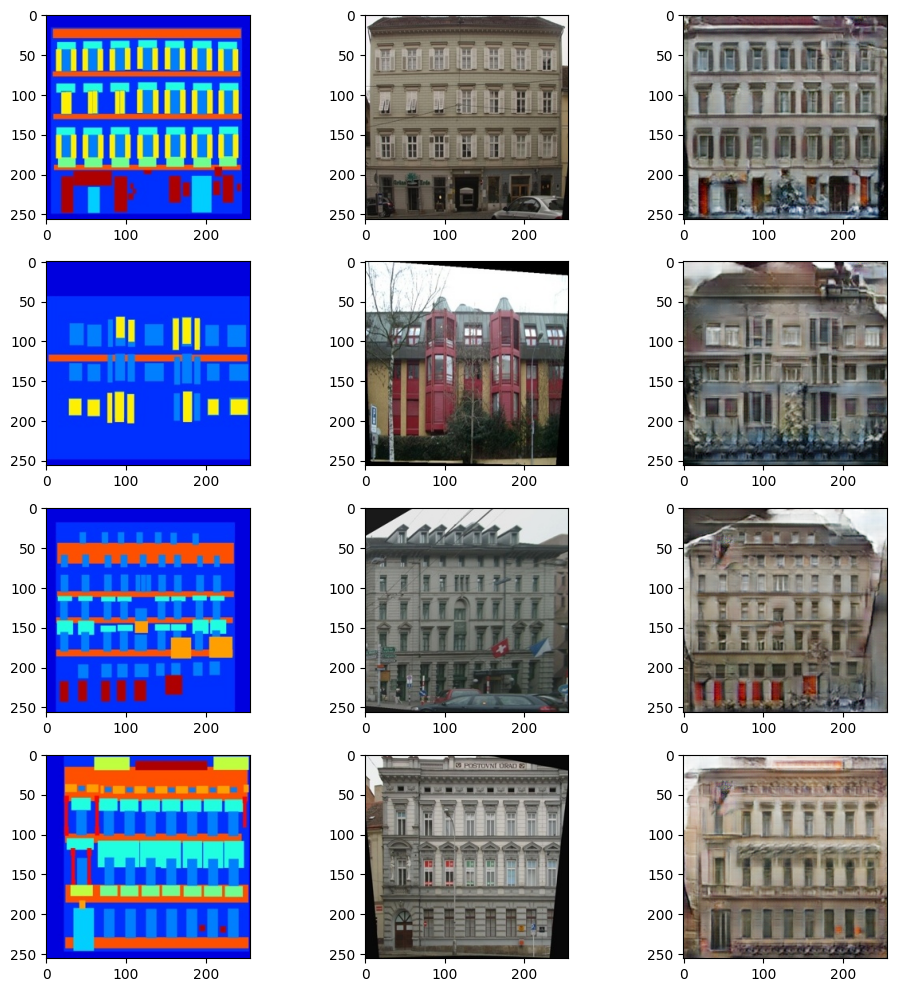

In [41]:
def visualise_inference(model_file, dataset, indexes):
    generator_model = UnetGenerator().to(device)
    generator_model.load_state_dict(torch.load(model_file))
    
    figure, axes = plt.subplots(nrows=len(indexes), ncols=3, figsize=(10, 10))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]

        input = torch.tensor(np.expand_dims(label, 0))
        fake = generator_model(input)
        fake = fake.detach().numpy()

        fake = np.transpose(fake[0], (1,2,0))
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))

        axes[i, 0].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
        axes[i, 1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i, 2].imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))

    column_names = [ 'Condition', 'Real', 'Fake']
    for i, ax in enumerate(axes.flatten()[:2]):
        ax.axis('off')
        ax.set_title(column_names[i], fontweight='bold')

    fig.subplots_adjust(hspace=0.5, bottom=0.1)
    plt.tight_layout(pad=1)
    plt.show()    

In [ ]:
validation_samples = np.random.choice(range(len(facades_val_dataset)), 6)

In [ ]:
visualise_inference(os.path.join(weights_dir, 'generator-197-16.008.pt'), facades_val_dataset, validation_samples)

In [ ]:
visualise_inference(os.path.join(weights_dir, 'generator-197-16.008.pt'), facades_val_dataset, validation_samples)

The results look extremelly plausible. It seems that the generator was able to learn the underlying distribution.